In [1]:
#!pip install pyEDFlib
#!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
#from pyedflib import highlevel
import pickle
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
import torch.optim as optim
import torchvision.models as models
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
device

device(type='cuda', index=0)

In [3]:
labels = {}
#W, R, 1, 2, 3, 4, M 
labels['W']=5
labels['R']=6
labels['M']=0
labels['1']=1
labels['2']=2
labels['3']=3
labels['4']=4
labels['e']=7

In [4]:
def load_data(dataset):
    batch_size=32
    validation_split = .2
    shuffle_dataset = True
    random_seed= 42
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)

    return train_loader, val_loader

In [5]:
def match_files(folder):
    files = os.listdir(folder)
    files = files[:200]
    output = {}
    for f in files:
        subject = f.split("-")[0][:6]
        f_type = f.split("-")[1]
        val = output.get(subject, {})
        val[f_type]=folder +f
        output[subject]=val
    keys = []
    for i in output.keys():
        if len(output[i])!= 2:
            keys.append(i)
    for key in keys: del output[key]
    return output

In [6]:
class CustomResNet18Dataset(Dataset):
    def __init__(self, file_list):
        self.x = []
        self.y = []
        #cnt = 0
        for i in file_list.keys():
           #if cnt !=4: 
              self.parse(file_list[i]["PSG.edf"], file_list[i]["Hypnogram.edf"])
              #cnt = cnt+1
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)

        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if (sleep_stage != '?') and (sleep_stage !='W') and (sleep_stage != 'R') and (sleep_stage != 'e'):
                for i in range(start, start+end, 30):
                # pick i to i +30 for target range end
                    x = np.asarray([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    _,_,x = spectrogram(x, fs=100)  
                    x = np.transpose(x,(1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    x = std * x + mean  #all pre-trained models expect input images normalized in the same way
                    x = np.clip(x, 0, 1)
                    x = np.transpose(x,(2, 0, 1))
                    self.x.append(x)
                    self.y.append(labels[sleep_stage])
    def __len__(self):

        return len(self.y)

    
    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])

In [7]:
##reload data from file
#sp_dataset= CustomResNet18Dataset(match_files("/content/drive/MyDrive/CS598/sleep-cassette//"))

##use preload data from the file
#filename = '/content/drive/MyDrive/CS598/resNet18WithDataStdMean_dataset.pkl' #normalized data with dateset std
filename = '/content/drive/MyDrive/CS598/resNet18_dataset.pkl' #normalized data with resnet18 default std
infile = open(filename,'rb')
sp_dataset = pickle.load(infile)
infile.close()

##Load Train and validation data 
train_loader, val_loader = load_data(sp_dataset)


In [8]:
##create resnet 18 model
resnet18  = models.resnet18(pretrained=True)
resnet18.to(device)
##redefine output predictions 
fc_in_channel = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in_channel, 5)
resnet18.fc = resnet18.fc.to(device)  

In [9]:
#Define criterion and opimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

In [10]:
train_loss = []

In [11]:
##train
n_epochs = 35

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    model.train()# prep model for training

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(True):
            outputs = model(data)
            outputs = outputs.to(device)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
           
        curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        train_loss.append(np.mean(curr_epoch_loss))
    return model

In [12]:
train_model(resnet18, train_loader,n_epochs, optimizer, criterion)

Epoch 0: curr_epoch_loss=0.6269856691360474
Epoch 1: curr_epoch_loss=0.49914756417274475
Epoch 2: curr_epoch_loss=0.4830596148967743
Epoch 3: curr_epoch_loss=0.3119065761566162
Epoch 4: curr_epoch_loss=0.35909533500671387
Epoch 5: curr_epoch_loss=0.5658336281776428
Epoch 6: curr_epoch_loss=0.2250174582004547
Epoch 7: curr_epoch_loss=0.4682854115962982
Epoch 8: curr_epoch_loss=0.3849513828754425
Epoch 9: curr_epoch_loss=0.40715593099594116
Epoch 10: curr_epoch_loss=0.32233095169067383
Epoch 11: curr_epoch_loss=0.273234486579895
Epoch 12: curr_epoch_loss=0.31013280153274536
Epoch 13: curr_epoch_loss=0.5926197171211243
Epoch 14: curr_epoch_loss=0.49056050181388855
Epoch 15: curr_epoch_loss=0.23909851908683777
Epoch 16: curr_epoch_loss=0.2634694576263428
Epoch 17: curr_epoch_loss=0.25198307633399963
Epoch 18: curr_epoch_loss=0.2021307796239853
Epoch 19: curr_epoch_loss=0.25329795479774475
Epoch 20: curr_epoch_loss=0.2164166420698166
Epoch 21: curr_epoch_loss=0.24282899498939514
Epoch 22: c

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def eval_model(model, dataloader):
    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        _,outputs = torch.max(outputs, dim = 1)
        Y_pred.append(outputs.cpu())
        Y_test.append(target.cpu().detach().numpy())
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_pred, y_true = eval_model(resnet18, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))
f1 = f1_score(y_true, y_pred,average='weighted')
print(("F1 Score: : " + str(f1)))

Validation Accuracy: 0.8081028262176789
F1 Score: : 0.8055518458275455


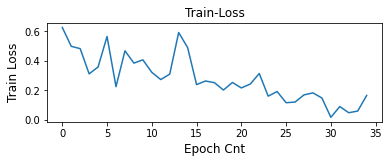

In [15]:
fig = plt.figure()
#Plot1
plot1 = fig.add_subplot(211)
plt.title("Train-Loss")
plt.xlabel('Epoch Cnt', fontsize=12)
plt.ylabel('Train Loss', fontsize=12)
plot1.plot(train_loss, label='Train Loss')


[1 2 3 4]
[2256 8971 1315  762]
[1 2 3 4]
[1874 9339 1378  713]


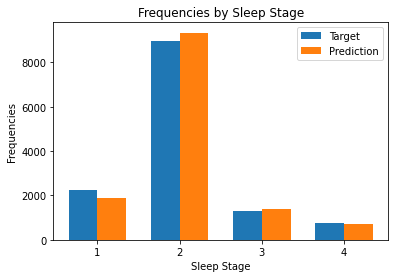

In [16]:
width = 0.35   
target_annotationList = y_true
(target_unique, target_counts) = np.unique(target_annotationList, return_counts=True)

print(target_unique)
print(target_counts)

pred_annotationList = y_pred
(pred_unique, pred_counts) = np.unique(pred_annotationList, return_counts=True)

print(pred_unique)
print(pred_counts)

plt.bar(target_unique, target_counts, width, label='Target')
plt.bar(pred_unique + width, pred_counts, width,label='Prediction')

plt.xlabel('Sleep Stage')
plt.ylabel('Frequencies')
plt.title('Frequencies by Sleep Stage')
plt.xticks(target_unique + width / 2, target_unique)
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix 
cf_matrix = confusion_matrix(y_true, y_pred) 
print(cf_matrix)

[[1402  847    7    0]
 [ 466 8094  388   23]
 [   4  370  753  188]
 [   2   28  230  502]]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True, 
                          figsize=None,
                          cmap='Blues',
                          title=None):  
   
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
 
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="", 
                linewidths=.2,  
                linecolor="black", 
                 
                cmap=cmap,cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
  
    plt.ylabel('True label - Sleep Stages')
    plt.xlabel('Predicted label - Sleep Stages') 
    
    if title:
        plt.title(title)

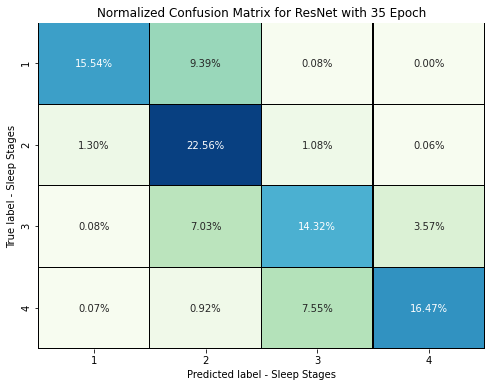

In [19]:
# title = "Confusion Matrix for 1D-CNN with 35 Epoch" 
# categories = [1,2,3,4]
# create_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False, title=title,
#                       categories = categories, cmap="GnBu")

title = "Normalized Confusion Matrix for ResNet with 35 Epoch" 
categories = [1,2,3,4]
# Normalize #
conf_mat_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
create_confusion_matrix(conf_mat_normalized, figsize=(8,6), count=False, cbar=False, title=title,
                      categories = categories, cmap="GnBu")